In [25]:
%matplotlib inline
 
import numpy as np
import pandas as pd
import sklearn as sk
 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import graphviz # needed to visualize trained decision tree [optional]
from sklearn.tree import export_graphviz # needed to visualize trained decision tree

We begin with reading in our data and doing some initial cleaning.

In [119]:
# Read in data
data = pd.read_csv('data.csv')

# Filter out new data
data_current = data[data.year >= 2010]

# Remove duplicate values based on id
data_current = data_current.drop_duplicates(subset=['id'],keep='first',inplace=False)
data_current.shape # shape matches what we have in R; we're good here.

(26711, 19)

In [120]:
# Creating a new popularity dummy variable
def groups(series):
    if 75 <= series <= 100:
        return 3
    elif 50 <= series < 75:
        return 2
    elif 25 <= series < 50:
        return 1
    elif series < 25:
        return 0
data_current['popDummy'] = data_current['popularity'].apply(groups)

# Converting duration_ms to seconds
data_current['duration_s'] = data_current['duration_ms']*.001

# Recoding year variable
def groups(series):
    if series == 2010:
        return 0
    elif series == 2011:
        return 1
    elif series == 2012:
        return 2
    elif series == 2013:
        return 3
    elif series == 2014:
        return 4
    elif series == 2015:
        return 5
    elif series == 2016:
        return 6
    elif series == 2017:
        return 7
    elif series == 2018:
        return 8
    elif series == 2019:
        return 9
    elif series == 2020:
        return 10
    elif series == 2021:
        return 11
data_current['year_factor'] = data_current['year'].apply(groups)

list(data_current)
data_current['loudness']

9087     -17.796
9091     -18.168
9111     -14.118
9117     -15.533
9119     -14.087
9121     -12.661
9129     -22.676
9137     -21.606
9139     -15.078
9143     -12.420
9147     -22.268
9149     -19.645
9173      -4.614
9181      -8.897
9183     -10.278
9197     -14.490
9233      -4.233
15863    -13.820
15869    -13.791
15879     -3.565
15883     -6.116
15885     -5.020
15897    -12.259
15899     -5.656
15901     -7.001
15905     -8.382
15925     -8.325
15935     -5.296
15943     -8.431
15979     -9.187
           ...  
174329    -4.662
174331    -6.652
174333    -8.355
174335    -9.405
174337   -14.414
174339    -7.454
174341    -7.135
174343   -10.920
174345    -5.545
174347   -11.742
174349    -1.957
174351    -7.067
174353   -11.722
174355   -10.151
174357    -5.648
174359    -3.110
174361    -7.301
174363   -24.280
174365   -25.111
174367   -24.280
174369   -30.008
174371   -30.915
174373   -24.280
174375   -24.121
174377   -11.665
174379   -11.665
174381   -11.665
174383   -11.6

In [121]:
from sklearn.feature_selection import SelectKBest, chi2

sel_chi2 = SelectKBest(chi2, k=7)    # select 4 features
data_subset_test = data_current
data_subset_test['loudness'] = abs(data_subset_test['loudness'])
X = data_subset_test[['explicit','instrumentalness','loudness','duration_s','year_factor','tempo','liveness','energy','danceability','key','mode','speechiness','valence']]
Y = data_subset_test['popDummy']
X_train_chi2 = sel_chi2.fit_transform(X,Y)
print(sel_chi2.get_support())

[ True  True  True  True  True  True  True False False False False False
 False]


In [122]:
# Subsetting our data to use for model--let's call this 'spotify'
#spotify = data_current[['popDummy','instrumentalness','explicit','loudness','duration_s','liveness','year_factor']]
spotify = data_current[['popDummy','explicit','instrumentalness','loudness','duration_s','year_factor','tempo','liveness']]

# We're going to only use data from 2010-2021, and predict 2021.
spotify_new = spotify[spotify.year_factor == 11]
spotify = spotify[spotify.year_factor < 11]

# Just a quick look-through to make sure the data is good
print(spotify.head())

      popDummy  explicit  instrumentalness  loudness  duration_s  year_factor  \
9087         1         0          0.000000    17.796     187.333            8   
9091         1         0          0.000005    18.168     236.800            8   
9111         0         0          0.000022    14.118     313.093           10   
9117         0         0          0.000162    15.533     295.093           10   
9119         0         0          0.000015    14.087     183.440           10   

        tempo  liveness  
9087  117.153    0.9040  
9091   82.332    0.6830  
9111  117.072    0.7980  
9117  115.864    0.0986  
9119   88.303    0.1470  


In [123]:
print(list(spotify.columns))

['popDummy', 'explicit', 'instrumentalness', 'loudness', 'duration_s', 'year_factor', 'tempo', 'liveness']


In [124]:
print(spotify.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25318 entries, 9087 to 174188
Data columns (total 8 columns):
popDummy            25318 non-null int64
explicit            25318 non-null int64
instrumentalness    25318 non-null float64
loudness            25318 non-null float64
duration_s          25318 non-null float64
year_factor         25318 non-null int64
tempo               25318 non-null float64
liveness            25318 non-null float64
dtypes: float64(5), int64(3)
memory usage: 1.7 MB
None


Things to consider:
    - change instrumentalness variable to factor?
    - ensure explicit, key, mode, and year are factors

MODEL SELECTION

In [125]:
train, test = train_test_split(spotify, test_size = 0.2, random_state = 123)

# Creating dataframes for the training/test inputs/target
train_X = train.drop(['popDummy'], axis=1)
train_Y = train["popDummy"]
test_X = test.drop(['popDummy'], axis=1)
test_Y = test["popDummy"]

test_Y.size

5064

In [126]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20254 entries, 75235 to 142971
Data columns (total 7 columns):
explicit            20254 non-null int64
instrumentalness    20254 non-null float64
loudness            20254 non-null float64
duration_s          20254 non-null float64
year_factor         20254 non-null int64
tempo               20254 non-null float64
liveness            20254 non-null float64
dtypes: float64(5), int64(2)
memory usage: 1.2 MB


1. Multinomial logisitic regression

In [127]:
# Declare model
lr_model = LogisticRegression()

# Fitting model on training data
lr_model.fit(train_X,train_Y)

# Printing our our predicted values
Y_hat = lr_model.predict(test_X)
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[0 0 0 0 0 2 0 0 0 0 0 0 2 2 0 0 2 0 0 2 0 2 2 0 2 0 0 2 2 0 2 0 2 0 2 2 0
 0 0 2 0 0 3 0 0 0 0 0 0 0 3 2 0 0 0 0 0 2 0 0 2 0 2 0 0 2 0 0 0 0 0 0 2 0
 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0
 0 2 2 0 0 2 0 0 0 3 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 2 2 0 2 0 0 0 0 0 0 0
 0 2 2 0 2 2 0 0 0 0 2 0 3 2 0 0 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 2 0 0 0 2 3
 0 0 2 3 0 0 2 2 0 0 2 0 2 0 0 0 2 2 2 0 0 0 2 0 2 0 0 2 0 0 2 0 2 0 2 0 2
 2 2 0 0 2 0 0 0 0 2 2 0 2 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 2 2 0 0 2 0 0 0 0 0 0 2 0 0 2 0
 0 0 0 0 2 2 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 2 3 0 2 2 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 3 0 2 2 0 0 0 0 0 2 2 0 0 0 0 2
 2 0 0 2 2 0 0 0 0 0 0 2 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 0 2 0 0 0 0 0 2 2 0 3 0 0 0 0 3 0 0 0 0 2 0 3 0 0 0 2 0 0 0 0 0 0 2 0 2 2
 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 2 0 0 0 0 2
 2 0 2 0 3 3 0 0 0 0 0 0 

/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [128]:
# confusion matrix
conf_matrix = confusion_matrix(test_Y,Y_hat)
print(conf_matrix)

[[2419    0  372   34]
 [ 106    0   62    2]
 [ 917    0  838   35]
 [ 183    0   53   43]]


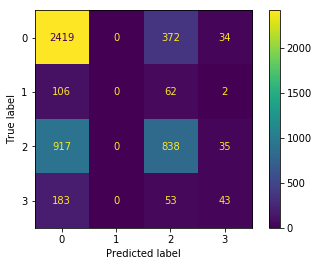

In [129]:
plot_confusion_matrix(lr_model, test_X, test_Y)

In [130]:
# classification report
print(classification_report(Y_hat,test_Y))
# warning; most likely due to all predictions being 0

              precision    recall  f1-score   support

           0       0.86      0.67      0.75      3625
           1       0.00      0.00      0.00         0
           2       0.47      0.63      0.54      1325
           3       0.15      0.38      0.22       114

    accuracy                           0.65      5064
   macro avg       0.37      0.42      0.38      5064
weighted avg       0.74      0.65      0.68      5064



/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
# accuracy measure
print(accuracy_score(Y_hat,test_Y))

0.6516587677725119


2. kNN 

In [132]:
# First find the optimal # of neighbors
scores = []
for i in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors = i)
    knn_model.fit(train_X, train_Y)
    y_model = knn_model.predict(test_X)
    scores.append(accuracy_score(test_Y, y_model))
    
max_val = max(scores)
print(max_val, scores.index(max_val))

0.6660742496050553 14


In [133]:
k = scores.index(max_val)

# Create model object
knn_model = KNeighborsClassifier(k)

# Train model
knn_model.fit(train_X, train_Y)

# Test model
Y_hat = knn_model.predict(test_X)

# Printing our our predicted values
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[0 0 0 2 0 2 2 0 2 0 2 0 2 0 0 2 2 0 0 2 0 2 2 0 0 2 0 2 2 2 2 0 0 0 2 0 0
 0 2 2 2 0 2 2 0 2 0 0 0 0 2 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 2 0 0 0 0 0 2 0
 2 2 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 2 2 0 0
 0 2 0 0 0 2 2 0 2 0 0 0 0 0 2 2 0 2 2 2 0 0 2 0 0 0 2 2 0 2 0 0 0 0 0 0 0
 2 0 0 2 0 0 0 0 0 0 2 0 0 2 0 2 0 0 2 2 0 0 2 2 0 0 2 0 2 2 0 0 0 2 0 0 0
 2 0 2 0 0 2 2 2 0 2 2 0 2 0 0 2 0 2 2 0 0 0 0 2 0 2 0 2 2 0 2 0 2 2 2 0 2
 2 2 2 0 2 0 2 0 0 2 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 2
 0 2 0 0 0 0 0 0 2 0 0 2 0 0 2 2 0 0 2 0 0 2 2 0 2 2 0 0 0 2 0 0 0 0 0 2 2
 0 0 0 0 0 2 0 2 0 0 0 0 0 2 2 0 0 0 0 2 0 2 0 0 2 0 2 2 0 0 0 2 0 0 2 2 2
 0 0 2 0 0 2 0 0 0 0 0 0 2 0 2 2 2 0 2 0 0 2 0 0 2 0 0 0 0 2 0 0 0 2 0 0 2
 0 0 0 2 2 0 2 0 2 0 0 2 0 0 0 0 0 0 2 2 0 0 2 0 0 0 2 0 0 0 2 0 0 0 2 2 2
 0 2 0 2 0 2 0 0 2 0 0 0 0 3 0 0 0 0 0 2 2 0 2 2 0 0 2 0 0 2 0 2 0 2 0 2 2
 0 2 0 2 0 2 0 0 0 2 0 0 2 0 2 2 0 0 2 0 2 0 2 2 0 2 0 2 2 0 0 2 0 0 0 2 0
 0 0 2 0 2 2 0 0 2 0 0 0 

In [134]:
# confusion matrix
conf_matrix = confusion_matrix(test_Y, Y_hat)
print(conf_matrix)

[[2237    1  579    8]
 [ 102    5   62    1]
 [ 671    0 1108   11]
 [ 128    0  146    5]]


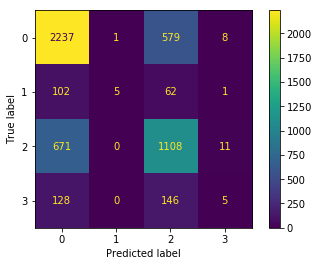

In [135]:
plot_confusion_matrix(knn_model, test_X, test_Y)

In [136]:
# classification report
print(classification_report(test_Y, Y_hat))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      2825
           1       0.83      0.03      0.06       170
           2       0.58      0.62      0.60      1790
           3       0.20      0.02      0.03       279

    accuracy                           0.66      5064
   macro avg       0.58      0.36      0.36      5064
weighted avg       0.64      0.66      0.63      5064



In [137]:
# accuracy measure
print("Accuracy: ", accuracy_score(test_Y,Y_hat))

Accuracy:  0.6625197472353871


3. Classification tree

In [138]:
## Let's train models over a range of depths, and score them with the test set
from sklearn.metrics import f1_score

acc_scores = [] # accuracy scores
f1_scores = [] # F1-scores
max_max = 20 # maximum depth
max_depth = np.arange(1, max_max) # range of 1:20 of depths to try

for depth in max_depth:
    # Build model and train
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=123) # not tuning # samples per leaf. setting random seed
    tree_model.fit(train_X, train_Y)

    # Test
    acc_scores.append(tree_model.score(test_X, test_Y))
    y_test_hat = tree_model.predict(test_X)
    f1_scores.append(f1_score(test_Y, y_test_hat, average=None))
    #^ need to add average parameter to f1-score since this is a multi-class problem

# Print values for best test score
ix_best = np.argmax(acc_scores)
print('Best accuracy score is %0.3f, for max_depth=%d' % (acc_scores[ix_best], max_depth[ix_best]))
ix_best = np.argmax(f1_scores)
from sklearn.metrics import f1_score

acc_scores = [] # accuracy scores
f1_scores = [] # F1-scoresprint('Best F1-score is %0.3f, for max_depth=%d' % (f1_scores[ix_best], max_depth[ix_best]))

Best accuracy score is 0.727, for max_depth=9


In [143]:
# Classification tree

# Declare model w/ depth of best accuracy score
tree_model = DecisionTreeClassifier(max_depth=9, random_state=123)

# Train model
tree_model.fit(train_X, train_Y)

# Printing our our predicted values w/ depth of best accuracy score
Y_hat = tree_model.predict(test_X)
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[0 0 0 2 0 2 2 0 2 0 2 0 2 2 0 0 2 0 0 2 0 0 2 0 0 0 0 0 2 2 2 0 2 0 2 2 2
 0 2 2 0 0 2 0 0 2 0 0 0 0 2 2 0 0 0 2 2 0 0 2 2 0 0 2 0 2 2 2 0 0 0 0 2 0
 0 0 0 0 0 2 0 2 0 0 2 1 0 0 0 0 0 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 2 2 0 0
 0 2 0 0 0 0 2 2 0 3 0 2 0 0 2 2 0 2 2 2 2 2 2 2 0 0 2 2 0 2 0 0 0 2 0 0 2
 2 2 2 2 2 2 0 0 0 0 2 2 0 0 0 2 0 0 2 2 0 0 2 2 0 0 2 0 0 2 0 2 0 2 0 2 0
 0 0 2 0 0 0 2 2 0 2 0 3 2 0 0 2 2 2 2 1 0 0 0 2 2 2 0 2 0 0 2 0 2 2 2 0 2
 2 0 2 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 3
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 2 2 0 0 0 2 0 0 0 0 0 2 0
 0 0 0 0 2 2 0 2 0 0 0 0 2 2 2 0 2 2 0 0 2 0 0 2 2 0 2 2 2 0 0 0 2 0 2 1 2
 2 0 2 0 0 0 2 0 0 0 0 0 2 0 3 2 0 0 2 0 2 2 0 0 2 0 0 2 0 2 0 2 0 2 0 0 0
 0 3 0 2 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 2 0 0 0 2 0 2
 0 0 0 3 0 3 0 2 2 0 3 0 0 2 0 0 0 0 0 2 0 0 0 2 0 0 2 0 0 2 0 0 2 0 0 2 2
 0 3 0 0 0 0 0 0 0 2 2 2 2 2 0 2 2 0 2 0 2 0 2 0 2 2 2 2 0 0 0 2 2 0 0 2 2
 2 2 2 0 2 3 0 0 0 0 0 0 

In [144]:
# confusion matrix
conf_matrix = confusion_matrix(test_Y, Y_hat)
print(conf_matrix)

[[2302   23  476   24]
 [  81   16   72    1]
 [ 428    3 1321   38]
 [  95    0  143   41]]


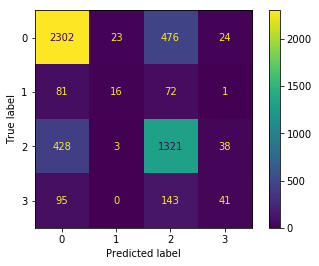

In [145]:
plot_confusion_matrix(tree_model, test_X, test_Y)

In [146]:
# classification report
print(classification_report(test_Y, Y_hat))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2825
           1       0.38      0.09      0.15       170
           2       0.66      0.74      0.69      1790
           3       0.39      0.15      0.21       279

    accuracy                           0.73      5064
   macro avg       0.56      0.45      0.47      5064
weighted avg       0.71      0.73      0.71      5064



In [147]:
# accuracy measure
print("Accuracy: ", accuracy_score(test_Y,Y_hat))

Accuracy:  0.7266982622432859


Testing our models on 2021 data:

In [148]:
X = spotify_new.drop(['popDummy'], axis=1)
Y = spotify_new['popDummy']

# Logistic regression
# Printing our our predicted values
Y_hat = lr_model.predict(X)
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0
 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 3 0 0 0 3 3 0 0 3 0 3 0 0 0 3 3 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 3 3 3 3 0 3 3 3
 0 0 0 0 0 0 3 3 0 0 0 3 0 3 3 0 0 3 0 0 0 0 0 0 0 0 3 0 0 3 3 0 0 0 3 3 3
 0 0 3 0 0 0 0 3 0 3 0 3 3 0 0 0 0 3 0 3 0 0 0 0 0 3 0 0 3 0 0 0 3 0 3 0 3
 0 0 0 0 3 3 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 3 3 0 0 3 0 3 0 0 3 0 0 3 0 3 0 0 0 0 0 0 3 3 3 3 0 0 0 0 0 0 3 0 0 3 0
 3 0 0 0 0 3 0 3 0 3 3 3 3 3 0 3 3 0 0 3 0 3 0 3 0 0 0 3 0 3 0 0 3 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 0 3 0 0 0 3
 0 0 3 3 3 3 0 2 0 0 0 0 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 0 3 0 3 3 3 3 3
 3 0 3 0 0 0 0 0 0 0 3 0 

In [40]:
# confusion matrix
conf_matrix = confusion_matrix(Y, Y_hat)
print(conf_matrix)

[[890   0  81 221]
 [ 36   0   3  16]
 [ 71   0  23  26]
 [ 15   0   6   5]]


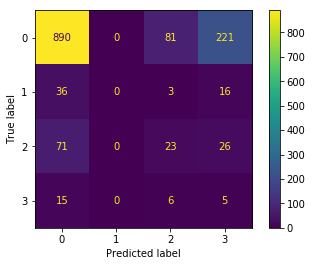

In [55]:
plot_confusion_matrix(lr_model, X, Y)

In [41]:
# classification report
print(classification_report(Y, Y_hat))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1192
           1       0.00      0.00      0.00        55
           2       0.20      0.19      0.20       120
           3       0.02      0.19      0.03        26

    accuracy                           0.66      1393
   macro avg       0.28      0.28      0.26      1393
weighted avg       0.77      0.66      0.71      1393



/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# accuracy measure
print("Accuracy: ", accuracy_score(Y,Y_hat))

Accuracy:  0.6590093323761665


In [43]:
# kNN, k = 9
# Printing our our predicted values
Y_hat = knn_model.predict(X)
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 0 3 0 2 0 3 0 3 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 2 0 0 3 2 0 0 3 3 2 3 0 3 2
 3 0 0 0 0 0 0 3 3 3 0 0 0 0 2 3 0 3 0 3 0 0 0 0 0 0 0 3 0 2 2 3 2 0 0 2 3
 0 0 0 0 0 0 0 0 0 2 0 2 3 0 0 3 0 0 3 3 0 3 0 0 0 0 3 0 3 3 3 0 3 0 0 0 3
 0 0 0 0 0 0 2 0 0 0 0 3 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 2 3 0
 0 0 0 0 0 3 2 0 2 0 0 0 0 0 0 3 2 0 0 0 0 0 0 0 0 3 0 0 2 0 3 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 3 0
 0 3 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 0 

In [44]:
# confusion matrix
conf_matrix = confusion_matrix(Y, Y_hat)
print(conf_matrix)

[[1035    3   73   81]
 [  45    0    1    9]
 [  84    0   11   25]
 [  11    0    5   10]]


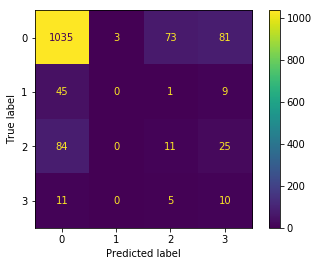

In [56]:
plot_confusion_matrix(knn_model, X, Y)

In [45]:
# classification report
print(classification_report(Y, Y_hat))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1192
           1       0.00      0.00      0.00        55
           2       0.12      0.09      0.10       120
           3       0.08      0.38      0.13        26

    accuracy                           0.76      1393
   macro avg       0.27      0.34      0.28      1393
weighted avg       0.77      0.76      0.76      1393



In [46]:
# accuracy measure
print("Accuracy: ", accuracy_score(Y,Y_hat))

Accuracy:  0.7580760947595119


In [149]:
# Classification tree

# Declare model w/ depth of best accuracy score
tree_model = DecisionTreeClassifier(max_depth=9, random_state=123)

# Train model
tree_model.fit(train_X, train_Y)

# Printing our our predicted values w/ depth of best accuracy score
Y_hat = tree_model.predict(test_X)
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[0 0 0 2 0 2 2 0 2 0 2 0 2 2 0 0 2 0 0 2 0 0 2 0 0 0 0 0 2 2 2 0 2 0 2 2 2
 0 2 2 0 0 2 0 0 2 0 0 0 0 2 2 0 0 0 2 2 0 0 2 2 0 0 2 0 2 2 2 0 0 0 0 2 0
 0 0 0 0 0 2 0 2 0 0 2 1 0 0 0 0 0 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 2 2 0 0
 0 2 0 0 0 0 2 2 0 3 0 2 0 0 2 2 0 2 2 2 2 2 2 2 0 0 2 2 0 2 0 0 0 2 0 0 2
 2 2 2 2 2 2 0 0 0 0 2 2 0 0 0 2 0 0 2 2 0 0 2 2 0 0 2 0 0 2 0 2 0 2 0 2 0
 0 0 2 0 0 0 2 2 0 2 0 3 2 0 0 2 2 2 2 1 0 0 0 2 2 2 0 2 0 0 2 0 2 2 2 0 2
 2 0 2 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 3
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 2 2 0 0 0 2 0 0 0 0 0 2 0
 0 0 0 0 2 2 0 2 0 0 0 0 2 2 2 0 2 2 0 0 2 0 0 2 2 0 2 2 2 0 0 0 2 0 2 1 2
 2 0 2 0 0 0 2 0 0 0 0 0 2 0 3 2 0 0 2 0 2 2 0 0 2 0 0 2 0 2 0 2 0 2 0 0 0
 0 3 0 2 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 2 0 0 0 2 0 2
 0 0 0 3 0 3 0 2 2 0 3 0 0 2 0 0 0 0 0 2 0 0 0 2 0 0 2 0 0 2 0 0 2 0 0 2 2
 0 3 0 0 0 0 0 0 0 2 2 2 2 2 0 2 2 0 2 0 2 0 2 0 2 2 2 2 0 0 0 2 2 0 0 2 2
 2 2 2 0 2 3 0 0 0 0 0 0 

In [150]:
# confusion matrix
conf_matrix = confusion_matrix(test_Y, Y_hat)
print(conf_matrix)

[[2302   23  476   24]
 [  81   16   72    1]
 [ 428    3 1321   38]
 [  95    0  143   41]]


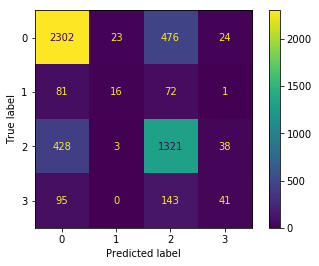

In [151]:
plot_confusion_matrix(tree_model, test_X, test_Y)

In [152]:
# classification report
print(classification_report(test_Y, Y_hat))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2825
           1       0.38      0.09      0.15       170
           2       0.66      0.74      0.69      1790
           3       0.39      0.15      0.21       279

    accuracy                           0.73      5064
   macro avg       0.56      0.45      0.47      5064
weighted avg       0.71      0.73      0.71      5064



In [153]:
# accuracy measure
print("Accuracy: ", accuracy_score(test_Y,Y_hat))

Accuracy:  0.7266982622432859


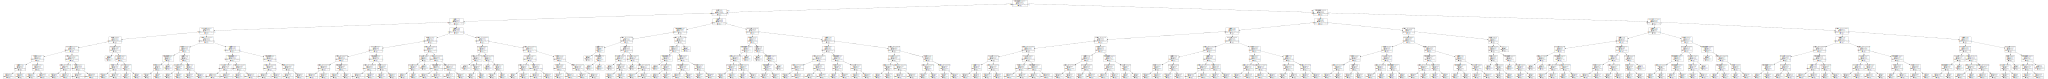

In [66]:
# Visualize the tree
from IPython.display import display
from sklearn.tree import export_graphviz

columns = list(train_X.columns)
#export_graphviz(tree_model, feature_names=columns, class_names=True, out_file="tree.dot")
display(graphviz.Source(export_graphviz(tree_model, feature_names=columns, class_names=True, out_file=None)))

Looks like kNN performs best! We were able to predict the 2021 songs' groups with around 75% accuracy.